In [1]:
import re
import pandas as pd

chinese_to_arabic = {
    '零': '0', '一': '1', '二': '2', '三': '3', '四': '4',
    '五': '5', '六': '6', '七': '7', '八': '8', '九': '9'
}

# 1. 剔除异常符号
def remove_unwanted_symbols(name):
    # 定义允许的字符：中文、英文、数字和常见符号（不想删除的符号）
    allowed_characters = r'[^\w\s\(\)（）【】「」『』]'
    # 删除所有不允许的符号
    return re.sub(allowed_characters, '', name)

# 2. 将各种括号转换成英文括号
def convert_brackets(name):
    # 替换中文和全角括号为标准英文括号
    return name.replace('（', '(').replace('）', ')') \
               .replace('【', '[').replace('】', ']') \
               .replace('「', '[').replace('」', ']') \
               .replace('『', '[').replace('』', ']')

# 3. 将汉字数字替换成阿拉伯数字
def replace_chinese_numbers(name):
    for ch_num, ar_num in chinese_to_arabic.items():
        name = name.replace(ch_num, ar_num)
    return name

# 4. 检查并调整括号匹配
def fix_unbalanced_brackets(name):
    left_count = name.count('(')
    right_count = name.count(')')
    
    # 如果左括号比右括号多，补齐右括号
    if left_count > right_count:
        name += ')' * (left_count - right_count)
    # 如果右括号比左括号多，补齐左括号
    elif right_count > left_count:
        name = '(' * (right_count - left_count) + name
    
    return name

# 5. 移除前面的数字和数字开头的部分
def remove_leading_numbers(name): 
    return re.sub(r'^\d+.*?(?=\D)', '', name).strip()  # re.sub(r'^\d+.*? ', '', name) 移除开头的数字直到第一个非数字字符，并去掉前后空格

    
# 综合清洗函数
def clean_fullname(name):
    if not isinstance(name, str):
        return name
    name = remove_unwanted_symbols(name)  # 剔除异常符号
    name = convert_brackets(name)  # 将括号转换成英文括号
    name = replace_chinese_numbers(name)  # 替换汉字数字为阿拉伯数字
    name = fix_unbalanced_brackets(name)  # 调整不平衡的括号
    name = remove_leading_numbers(name)  # 移除前面的数字
    return name.upper() # 转换为大写并去掉前后空格

# 对 fullname 列应用清洗操作

words_to_remove = [
    '有限', '责任', '股份', '公司', '厂', '省', '市', '区', '县',
    '回族自治区', '壮族自治区', '维吾尔自治区', '自治区'
]
# words_to_remove = [
#     '有限', '责任', '股份', '集团', '总公司', '分公司', '公司', '总院', '分院', '总部', '分部', '总厂', '厂', 
#     '省', '市', '区', '县', '回族自治区', '壮族自治区', '维吾尔自治区', '自治区'
# ]


# 1. 剔除特定词汇
def remove_specific_words(name):
    # 构建正则表达式，匹配列表中的词汇
    pattern = '|'.join(words_to_remove)
    # 替换这些词汇为空
    return re.sub(pattern, '', name)

# 2. 剔除括号和括号内的内容
def remove_brackets(name):
    # 删除所有括号和其中的内容
    return re.sub(r'\(.*?\)', '', name)

def remove_outer_brackets(name):
    # 删除括号但保留其中的内容
    return re.sub(r'[()]', '', name)

# 综合清洗得到企业简称
def clean_short_name(name):
    if not isinstance(name, str):
        return name
    name = remove_specific_words(name)  # 剔除特定词汇
    name = remove_brackets(name)  # 剔除括号及其中内容
    return name.strip()  # 去除首尾空格

In [2]:
patent_all=pd.read_csv('data\\patent_all_2410.csv',index_col=0)
patent_all.table_name.value_counts()

table_name
patent_incopat_202101_202211    5586621
patent202210                    1576086
patent202404                    1492032
patent202410                     688260
patent_incopat_202212_202312     586203
patent202309                      93815
patent202408                      46033
patent202407                      33097
Name: count, dtype: int64

In [3]:
patent_all['公开（公告）日']=pd.to_datetime(patent_all['公开（公告）日'])
patent_all['申请日']=pd.to_datetime(patent_all['申请日'])
patent_all['申请年']=patent_all['申请日'].dt.year

In [4]:
annual_qymc=pd.read_csv('data\sd_annual_qymc_1018.csv',index_col=0)
annual_qymc['企业全称'] = annual_qymc['qymc'].apply(clean_fullname)
annual_qymc['企业简称'] = annual_qymc['企业全称'].apply(clean_short_name).replace('',pd.NA)
annual_qymc['企业简称'].isna().sum(),annual_qymc['企业简称'].nunique()

(198, 2025019)

In [5]:
patent_all_2018=patent_all[(patent_all['申请年'] <= 2018)&(patent_all['申请人'].str.count(';')>0)]
patent_applicants_sort=patent_all_2018['申请人'].str.split(';').explode().str.strip().apply(clean_fullname).apply(clean_short_name).replace('',pd.NA)
patent_applicants_sort.nunique()

45505

In [6]:
matched_companies = set(annual_qymc.企业简称.unique())&set(patent_applicants_sort)
matching_patent_name=patent_applicants_sort[patent_applicants_sort.isin(matched_companies)]
patent_all_qymc = patent_all_2018.loc[matching_patent_name.index]
patent_all_qymc['企业简称_match']=matching_patent_name
len(patent_all_qymc),patent_all_qymc.申请号.nunique(),len(matched_companies)

(585612, 284063, 14986)

In [7]:
patent_all_qymc=patent_all_qymc.sort_values(['申请日','公开（公告）日']).drop_duplicates(['申请号','公开（公告）号','专利类型'],keep='first').reset_index(drop=True)#'企业简称_match'
patent_all_qymc.shape#(319264, 19)

(319264, 19)

In [8]:
patent_all_qymc['企业名称']=patent_all_qymc['申请人'].str.split(';').apply(lambda x: [i.strip() for i in x if i.strip()])
patent_all_qymc['企业简称']=patent_all_qymc['企业名称'].apply(lambda x: list(set(clean_short_name(clean_fullname(i)) for i in x)))
patent_all_qymc['企业简称'].explode().dropna().nunique()

25288

In [10]:
patent_all_qymc.columns

Index(['申请号', '申请日', '申请人', '公开（公告）号', '公开（公告）日', '首次公开日', '标题 (中文)', '专利类型',
       'IPC主分类', '引证申请人', '被引证申请人', '引证专利', '当前法律状态', '当前权利人', '工商统一社会信用代码',
       '工商上市代码', 'table_name', '申请年', '企业简称_match', '企业名称', '企业简称'],
      dtype='object')

In [13]:
from collections import defaultdict
import networkx as nx
import itertools
import igraph as ig

In [12]:
patent_all_qymc.申请年.unique()

array([1986., 1987., 1988., 1990., 1991., 1992., 1993., 1994., 1995.,
       1996., 1997., 1998., 1999., 2000., 2001., 2002., 2003., 2004.,
       2005., 2006., 2007., 2008., 2009., 2010., 2011., 2012., 2013.,
       2014., 2015., 2016., 2017., 2018.])

In [31]:
%%time
networks = defaultdict(nx.Graph)
for year in range(2004,2019):
    patent_year=patent_all_qymc[patent_all_qymc.申请年==year]
    if year not in networks:
        networks[year] = nx.Graph() #nx.MultiGraph()
         
    G= networks[year]
    for _, row in patent_year.iterrows():
        for pair in itertools.combinations(row['企业名称'], 2):
            G.add_edge(pair[0], pair[1]) #添加边时自动去重
            
    print(year)

2004
2005
2006
2007
2008
2009
2010
2011
2012
2013
2014
2015
2016
2017
2018
CPU times: total: 28.6 s
Wall time: 28.6 s


In [44]:
%%time
yearly_centrality =[]
for year, G in networks.items():
    centralities = {
    'degree_centrality': nx.degree_centrality(G),
    'betweenness_centrality': nx.betweenness_centrality(G, weight='weight'),
    'closeness_centrality': nx.closeness_centrality(G, distance='weight'),
    'eigenvector_centrality': nx.eigenvector_centrality(G, weight='weight')}
    
    df = pd.DataFrame(centralities)
    df['year'] = year
    df['company'] = df.index
    yearly_centrality.append(df)
    
centrality_df = pd.concat(yearly_centrality, ignore_index=True)
centrality_df

CPU times: total: 7min 56s
Wall time: 7min 57s


,degree_centrality,betweenness_centrality,closeness_centrality,eigenvector_centrality,year,company
0,0.001733,0.000000,0.001733,5.265359e-22,2004,时代集团公司
1,0.001733,0.000000,0.001733,5.265359e-22,2004,北京时代之峰科技有限公司
2,0.001733,0.000000,0.053211,1.865033e-02,2004,中体同方体育科技有限公司
3,0.019064,0.006701,0.069663,1.308120e-01,2004,清华大学
4,0.005199,0.000030,0.005546,1.211154e-16,2004,彩虹集团电子股份有限公司
...,...,...,...,...,...,...
53955,0.000162,0.000000,0.000162,5.223849e-19,2018,河南森源城市环境科技服务有限公司
53956,0.000162,0.000000,0.000162,5.223849e-19,2018,南通醋酸化工股份有限公司
53957,0.000162,0.000000,0.000162,5.223849e-19,2018,南通宏信化工有限公司
53958,0.000162,0.000000,0.000216,9.060503e-18,2018,中铁十四局集团有限公司


In [45]:
centrality_df.to_csv('data//tax_centrality_2018.csv',  encoding="utf_8_sig")

In [94]:
%%time
yearly_matrices = {}
for year, group in patent_all_qymc[patent_all_qymc.申请年>=2004].groupby('申请年'):
    all_companies = group['企业名称'].explode().dropna().unique()
    matrix = pd.DataFrame(0, index=all_companies, columns=all_companies)
    
    for companies in group.drop_duplicates(subset=['申请号'])['企业名称'].dropna():
        for pair in itertools.combinations(companies, 2):
            matrix.loc[pair[0], pair[1]] += 1
            matrix.loc[pair[1], pair[0]] += 1  
    
    yearly_matrices[year] = matrix

    print(year,matrix.shape)

yearly_matrices[2004]

2004.0 (578, 578)
2005.0 (805, 805)
2006.0 (1049, 1049)
2007.0 (1345, 1345)
2008.0 (2079, 2079)
2009.0 (2847, 2847)
2010.0 (3408, 3408)
2011.0 (4030, 4030)
2012.0 (4630, 4630)
2013.0 (4952, 4952)
2014.0 (5093, 5093)
2015.0 (5278, 5278)
2016.0 (5601, 5601)
2017.0 (6098, 6098)
2018.0 (6167, 6167)
CPU times: total: 4min 2s
Wall time: 4min 3s


,时代集团公司,北京时代之峰科技有限公司,中体同方体育科技有限公司,清华大学,彩虹集团电子股份有限公司,咸阳彩秦电子器件有限责任公司,彩虹显示器件股份有限公司,江苏天容集团股份有限公司,江苏瑞禾化学有限公司,江苏中意化学有限公司,...,北京工业大学,中国人民解放军第二军医大学,广东一品红药业有限公司,同方股份有限公司,三九医药股份有限公司,南京京华生物工程有限公司,深圳市三诺电子有限公司,上海诚丰数码科技有限公司,上海诚丰数码设备有限公司,浙江巨化股份有限公司研究开发中心
时代集团公司,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
北京时代之峰科技有限公司,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
中体同方体育科技有限公司,0,0,0,2,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
清华大学,0,0,2,0,0,0,0,0,0,0,...,0,0,0,3,0,0,0,0,0,0
彩虹集团电子股份有限公司,0,0,0,0,0,1,5,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
南京京华生物工程有限公司,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
深圳市三诺电子有限公司,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
上海诚丰数码科技有限公司,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
上海诚丰数码设备有限公司,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0


In [96]:
matrix.values.sum().sum()/2#70844

70514.0

In [ ]:
yearly_centrality=[]
for year, matrix in yearly_matrices.items():
    G = nx.from_pandas_adjacency(matrix) #无向图
    degree_centrality = nx.degree_centrality(G)
    betweenness_centrality = nx.betweenness_centrality(G, weight='weight')
    closeness_centrality = nx.closeness_centrality(G, distance='weight')
    eigenvector_centrality = nx.eigenvector_centrality(G, weight='weight')

    df = pd.DataFrame({
    'degree_centrality': degree_centrality,
    'betweenness_centrality':  betweenness_centrality ,
    'closeness_centrality': closeness_centrality,
    'eigenvector_centrality': eigenvector_centrality})
    
    df['year'] = year
    df['company'] = df.index
    yearly_centrality.append(df)


In [55]:
%%time
# g = ig.Graph()
snapshots = {}
yearly_centrality = []
for year, group in patent_all_qymc[patent_all_qymc.申请年>=2004].groupby('申请年'):
    g = ig.Graph()
    applicants=group['企业名称'].explode().dropna().unique()
    g.add_vertices(applicants.tolist())
    for _, row in group.iterrows():
        edges = [(pair[0], pair[1]) for pair in itertools.combinations(row['企业名称'], 2)]
        g.add_edges(edges)#为每一对重复的企业名称添加边,每次生成的组合
            
    snapshots[year] = g.copy()

    centralities = {
    'degree_centrality':  g.degree(),
    'betweenness_centrality': g.betweenness(),
    'closeness_centrality': g.closeness(),
    'eigenvector_centrality':  g.eigenvector_centrality()
    }
    
    df = pd.DataFrame(centralities)
    df['year'] = year
    df['company'] = applicants  
    yearly_centrality.append(df)

    print(year)

yearly_centrality[-1]

,degree_centrality,betweenness_centrality,closeness_centrality,eigenvector_centrality,year,company
0,6203,955244.035305,0.255411,2.296644e-06,2018.0,中国石油化工股份有限公司
1,52,1641.208042,0.208650,3.042364e-08,2018.0,中国石油化工股份有限公司胜利油田分公司孤岛采油厂
2,1,0.000000,0.571429,0.000000e+00,2018.0,宜宾学院
3,99,6.000000,1.000000,0.000000e+00,2018.0,宜宾五粮液股份有限公司
4,3493,561.000000,1.000000,0.000000e+00,2018.0,京东方科技集团股份有限公司
...,...,...,...,...,...,...
6162,1,0.000000,1.000000,0.000000e+00,2018.0,河南森源城市环境科技服务有限公司
6163,9,0.000000,1.000000,0.000000e+00,2018.0,南通醋酸化工股份有限公司
6164,9,0.000000,1.000000,0.000000e+00,2018.0,南通宏信化工有限公司
6165,2,0.000000,0.666667,0.000000e+00,2018.0,中铁十四局集团有限公司


In [61]:
pd.concat(yearly_centrality, ignore_index=True)

,degree_centrality,betweenness_centrality,closeness_centrality,eigenvector_centrality,year,company
0,1,0.00,1.000000,2.147296e-18,2004.0,时代集团公司
1,1,0.00,1.000000,2.760810e-18,2004.0,北京时代之峰科技有限公司
2,2,0.00,0.238007,6.472378e-05,2004.0,中体同方体育科技有限公司
3,59,1113.55,0.311594,8.119570e-03,2004.0,清华大学
4,9,5.00,0.800000,2.699458e-17,2004.0,彩虹集团电子股份有限公司
...,...,...,...,...,...,...
53955,1,0.00,1.000000,0.000000e+00,2018.0,河南森源城市环境科技服务有限公司
53956,9,0.00,1.000000,0.000000e+00,2018.0,南通醋酸化工股份有限公司
53957,9,0.00,1.000000,0.000000e+00,2018.0,南通宏信化工有限公司
53958,2,0.00,0.666667,0.000000e+00,2018.0,中铁十四局集团有限公司


In [90]:
centrality_df = pd.concat(yearly_centrality, ignore_index=True)
centrality_df['企业简称']=centrality_df['company'].apply(clean_fullname).apply(clean_short_name).replace('',pd.NA)
centrality_df['企业简称'].isin(annual_qymc.企业简称.unique()).sum(),centrality_df['企业简称'].nunique(),centrality_df.loc[centrality_df['企业简称'].isin(annual_qymc.企业简称.unique()),'企业简称'].nunique()

(37305, 24714, 14768)

In [65]:
for year in snapshots.keys():
    g = snapshots[year]
    G = networks[year] 
    print(f"Year: {year}, igraph Nodes: {g.vcount()}, Edges: {g.ecount()}")
    print(f"Year: {year}, networkx Nodes: {G.number_of_nodes()}, Edges: {G.number_of_edges()}")

Year: 2004.0, igraph Nodes: 578, Edges: 1815
Year: 2004.0, networkx Nodes: 578, Edges: 470
Year: 2005.0, igraph Nodes: 805, Edges: 3559
Year: 2005.0, networkx Nodes: 805, Edges: 852
Year: 2006.0, igraph Nodes: 1049, Edges: 4186
Year: 2006.0, networkx Nodes: 1049, Edges: 968
Year: 2007.0, igraph Nodes: 1345, Edges: 10928
Year: 2007.0, networkx Nodes: 1345, Edges: 1433
Year: 2008.0, igraph Nodes: 2079, Edges: 9753
Year: 2008.0, networkx Nodes: 2079, Edges: 1929
Year: 2009.0, igraph Nodes: 2847, Edges: 14392
Year: 2009.0, networkx Nodes: 2847, Edges: 2616
Year: 2010.0, igraph Nodes: 3408, Edges: 18884
Year: 2010.0, networkx Nodes: 3408, Edges: 3409
Year: 2011.0, igraph Nodes: 4030, Edges: 24060
Year: 2011.0, networkx Nodes: 4030, Edges: 4044
Year: 2012.0, igraph Nodes: 4630, Edges: 36360
Year: 2012.0, networkx Nodes: 4630, Edges: 4728
Year: 2013.0, igraph Nodes: 4952, Edges: 52160
Year: 2013.0, networkx Nodes: 4952, Edges: 5424
Year: 2014.0, igraph Nodes: 5093, Edges: 48695
Year: 2014.0, 

In [14]:
%%time
snapshots = {}
yearly_centrality = []
for year, group in patent_all_qymc[patent_all_qymc.申请年>=2004].groupby('申请年'):
    g = ig.Graph() 
    applicants=group['企业简称'].explode().dropna().unique()#'企业名称'
    g.add_vertices(applicants.tolist())

    added_edges = set() 
    for _, row in group.iterrows():
        application_number = row['申请号']
        edges = [(pair[0], pair[1]) for pair in itertools.combinations(row['企业简称'], 2)]
        for edge in edges:
            if (application_number,edge) not in added_edges: #如果是不同的申请后的话 添加边 同一个申请号就去重
                g.add_edge(edge[0], edge[1]) #无向边
                added_edges.add((application_number,edge))
            
    snapshots[year] = g.copy()

    centralities = {
    'degree_centrality':  g.degree(),
    'betweenness_centrality': g.betweenness(),
    'closeness_centrality': g.closeness(),
    'eigenvector_centrality':  g.eigenvector_centrality()
    }
    
    df = pd.DataFrame(centralities)
    df['year'] = year
    df['company'] = applicants  
    yearly_centrality.append(df)

    print(year,len(added_edges), f'igraph Nodes: {g.vcount()}, Edges: {g.ecount()}')
    
centrality_df = pd.concat(yearly_centrality, ignore_index=True)
centrality_df

2004.0 1631 igraph Nodes: 574, Edges: 1631
2005.0 2833 igraph Nodes: 799, Edges: 2833
2006.0 3667 igraph Nodes: 1043, Edges: 3667
2007.0 10127 igraph Nodes: 1327, Edges: 10127
2008.0 8513 igraph Nodes: 2062, Edges: 8513
2009.0 12283 igraph Nodes: 2816, Edges: 12283
2010.0 16700 igraph Nodes: 3373, Edges: 16700
2011.0 21409 igraph Nodes: 3983, Edges: 21409
2012.0 31957 igraph Nodes: 4574, Edges: 31957
2013.0 45464 igraph Nodes: 4883, Edges: 45464
2014.0 42846 igraph Nodes: 5013, Edges: 42846
2015.0 51067 igraph Nodes: 5195, Edges: 51067
2016.0 57904 igraph Nodes: 5519, Edges: 57904
2017.0 68265 igraph Nodes: 5998, Edges: 68265
2018.0 70114 igraph Nodes: 6063, Edges: 70114
CPU times: total: 7min 57s
Wall time: 7min 58s


,degree_centrality,betweenness_centrality,closeness_centrality,eigenvector_centrality,year,company
0,1,0.00,1.000000,4.294592e-18,2004.0,北京时代之峰科技
1,1,0.00,1.000000,3.987836e-18,2004.0,时代集团
2,2,0.00,0.238722,6.471752e-05,2004.0,中体同方体育科技
3,57,1095.55,0.312808,8.118784e-03,2004.0,清华大学
4,8,5.00,0.800000,4.171890e-17,2004.0,彩虹集团电子
...,...,...,...,...,...,...
53217,1,0.00,1.000000,0.000000e+00,2018.0,河南森源重工
53218,9,0.00,1.000000,0.000000e+00,2018.0,南通醋酸化工
53219,9,0.00,1.000000,0.000000e+00,2018.0,南通宏信化工
53220,2,0.00,0.666667,0.000000e+00,2018.0,中铁十4局集团


In [15]:
centrality_df['company'].isin(annual_qymc.企业简称.unique()).sum(),centrality_df['company'].nunique(),centrality_df.loc[centrality_df['company'].isin(annual_qymc.企业简称.unique()),'company'].nunique()

(36730, 24715, 14768)

In [16]:
centrality_df.to_csv('data//tax_centrality_2018.csv',  encoding="utf_8_sig")

In [23]:
import matplotlib.pyplot as plt
from igraph import plot
plt.rcParams['font.sans-serif']='SimHei'

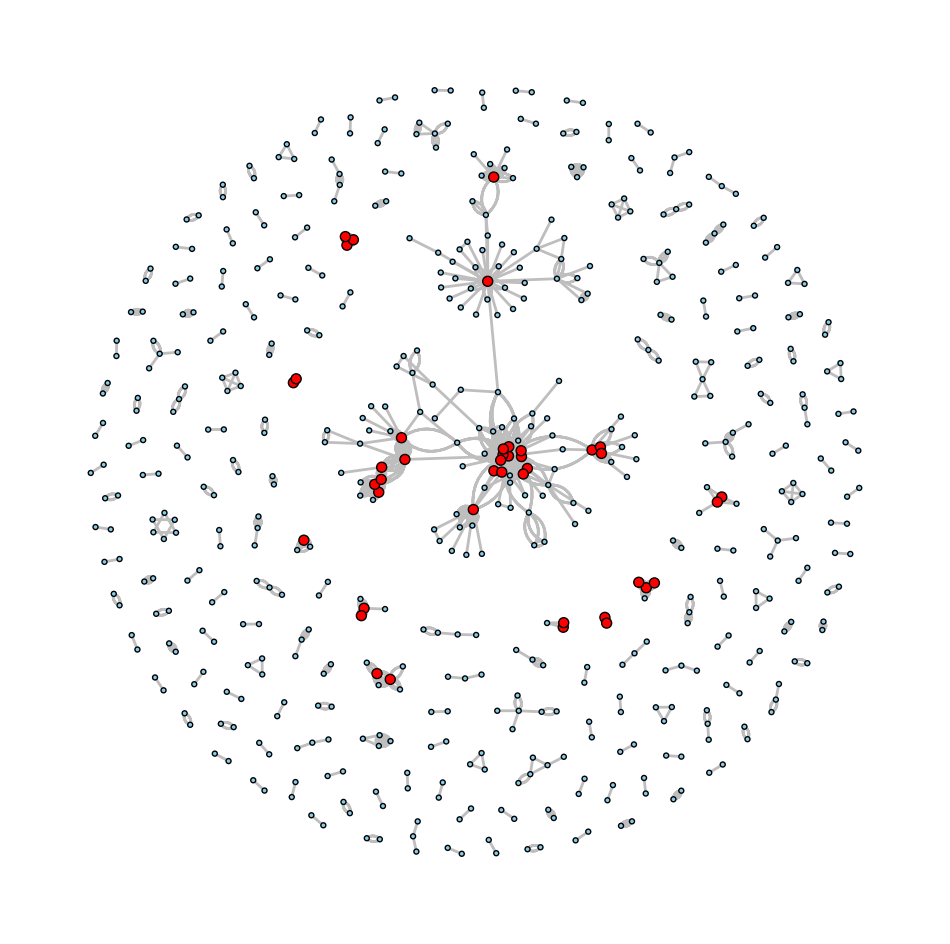

In [99]:
g=snapshots[2004]
g.vs["color"] = "skyblue"
g.es["color"] = "gray"
g.vs["size"] = 5  

degree_threshold = 10
high_degree_nodes = [v.index for v in g.vs if g.degree(v.index) > degree_threshold]
for node in high_degree_nodes:
    g.vs[node]["color"] = "red"
    g.vs[node]["size"] = 10 
    
fig, ax = plt.subplots(figsize=(12,12))
plot(g, target=ax) 
plt.show()

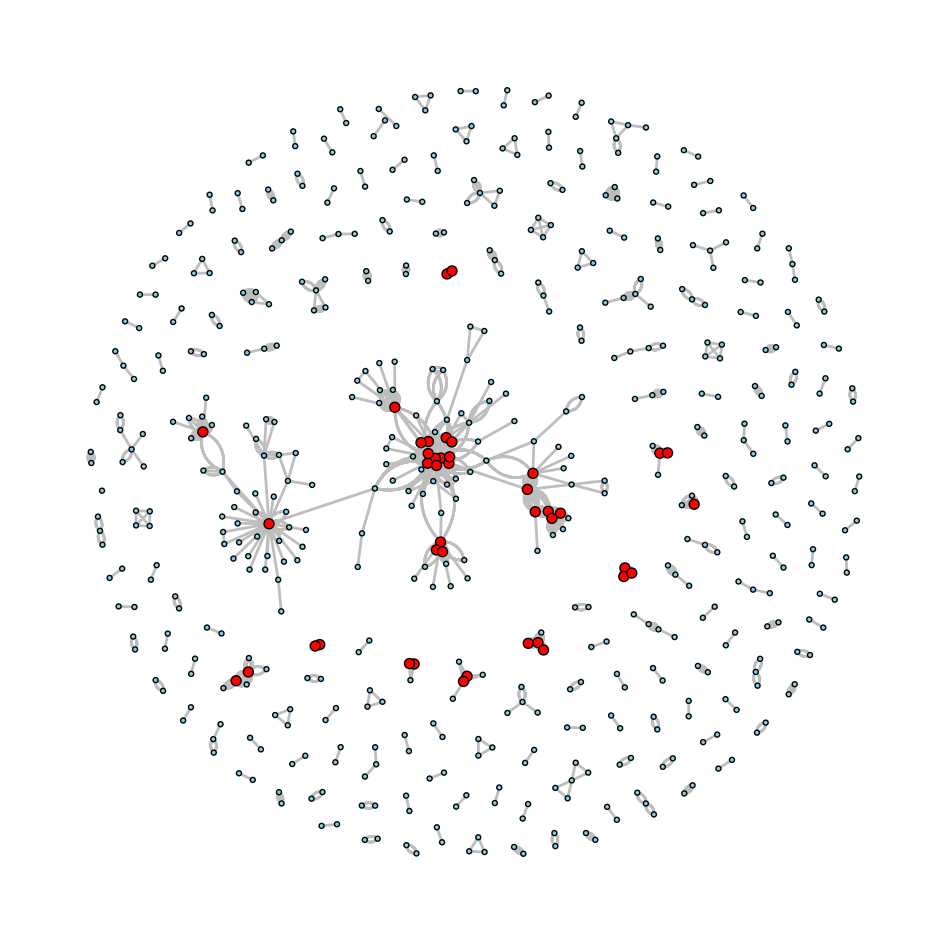

In [18]:
g=snapshots[2004]
g.vs["color"] = "skyblue"
g.es["color"] = "gray"
g.vs["size"] = 5  

degree_threshold = 10
high_degree_nodes = [v.index for v in g.vs if g.degree(v.index) > degree_threshold]
for node in high_degree_nodes:
    g.vs[node]["color"] = "red"
    g.vs[node]["size"] = 10 
    
fig, ax = plt.subplots(figsize=(12,12))
plot(g, target=ax) 
plt.show()

In [102]:
centrality_df['company'].value_counts()

company
北京中科信利技术有限公司             15
复旦大学                     15
中国石油化工股份有限公司石油勘探开发研究院    15
中国海洋石油总公司                15
东华大学                     15
                         ..
天津铂创国茂电子科技发展有限公司          1
苏州国芯科技有限公司                1
北京睿日车心科技有限公司              1
宁夏电力公司电力科学研究院             1
云南功东高速公路建设指挥部             1
Name: count, Length: 25414, dtype: int64

In [109]:
centrality_df.groupby('year').apply(lambda x: x.nlargest(3, 'degree_centrality')).reset_index(drop=True)

,degree_centrality,betweenness_centrality,closeness_centrality,eigenvector_centrality,year,company,企业简称
0,570,6683.108572,0.422951,1.000000e+00,2004.0,中国石油化工股份有限公司,中国石油化工
1,200,0.000000,0.304965,7.892756e-01,2004.0,中国石油化工股份有限公司石油化工科学研究院,中国石油化工石油化工科学研究院
2,112,23.500000,0.335065,4.345515e-01,2004.0,中国石油化工股份有限公司抚顺石油化工研究院,中国石油化工抚顺石油化工研究院
3,580,11106.522959,0.325509,1.000000e+00,2005.0,中国石油化工股份有限公司,中国石油化工
4,223,64.333333,0.261307,7.700099e-01,2005.0,中国石油化工股份有限公司石油化工科学研究院,中国石油化工石油化工科学研究院
5,140,0.000000,0.246154,4.852222e-01,2005.0,中国石油化工股份有限公司上海石油化工研究院,中国石油化工上海石油化工研究院
6,636,10734.022580,0.301221,6.459276e-15,2006.0,中国石油化工股份有限公司,中国石油化工
7,484,11.987245,1.000000,1.000000e+00,2006.0,深圳市海川实业股份有限公司,深圳海川实业
8,417,0.000000,0.600000,9.948284e-01,2006.0,深圳海川色彩科技有限公司,深圳海川色彩科技
9,2721,38.343895,0.714286,1.000000e+00,2007.0,深圳市海川实业股份有限公司,深圳海川实业


In [43]:
import numpy as np
g=snapshots[2018]
adjacency_list = g.get_adjacency().data  # 这是一个列表，包含边的连接信息
# 将邻接列表转换为 numpy 数组
adjacency_matrix = np.array(adjacency_list)
# 创建 NetworkX 图
G = nx.from_numpy_array(adjacency_matrix)
# 设置节点名称
mapping = {i: g.vs[i]['name'] for i in range(len(g.vs))}
G = nx.relabel_nodes(G, mapping)

# for vertex in g.vs:
#     G_nx.nodes[vertex['name']].update(vertex.attributes())

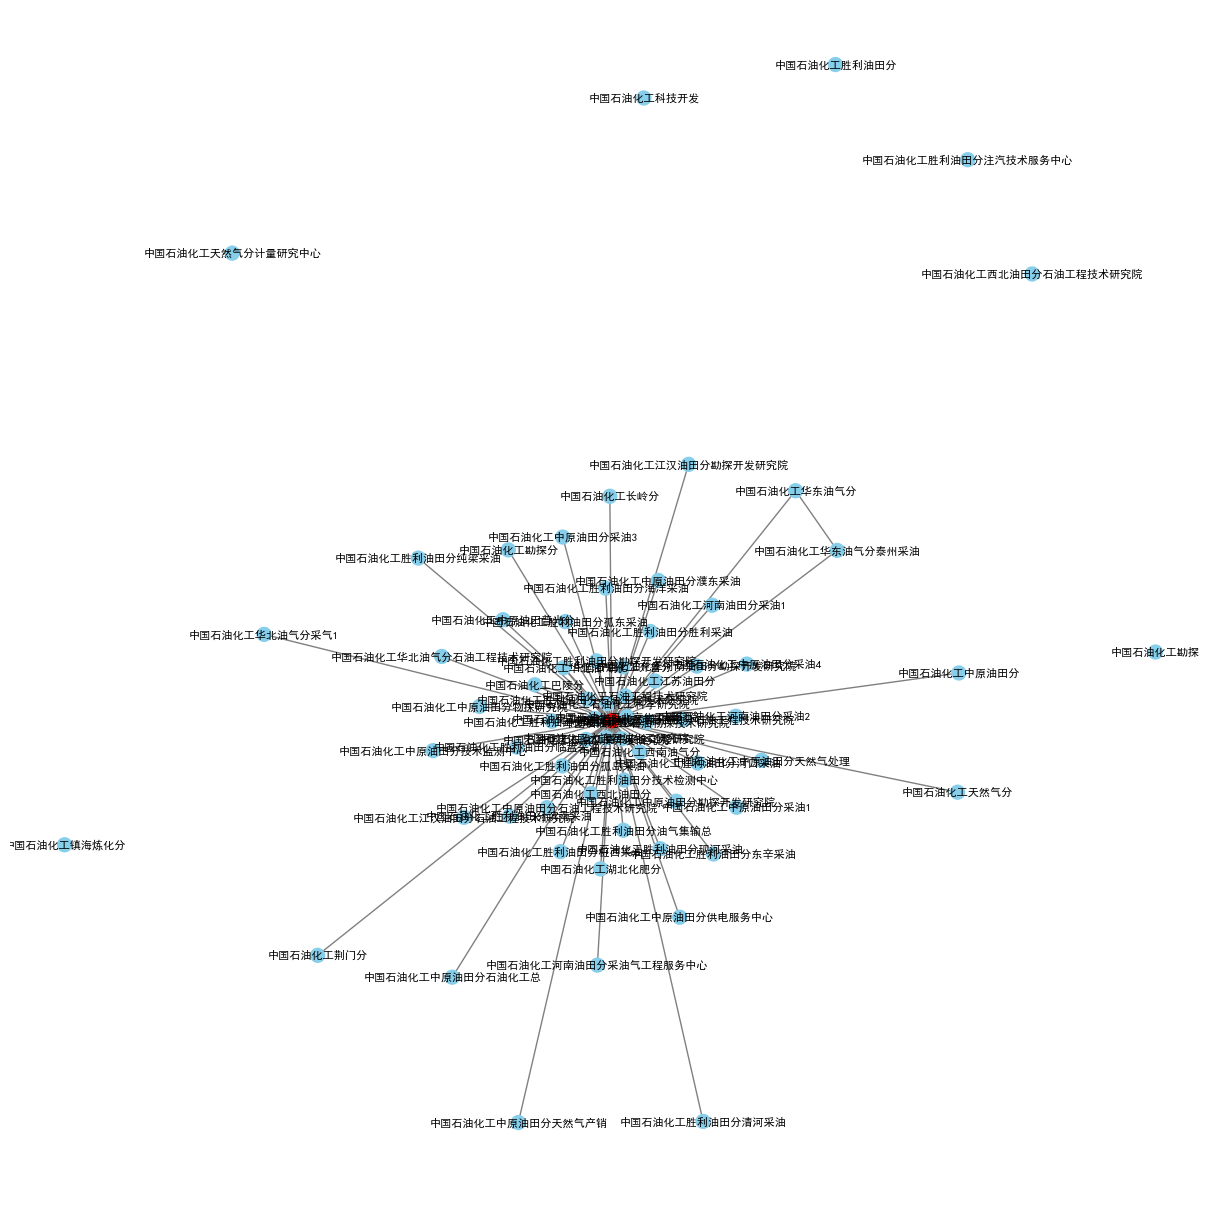

In [44]:
# target_company = "中国石油化工股份有限公司"
# G = networks[2018]
target_company = "中国石油化工"
target_nodes = [n for n in G.nodes if target_company in n]

# 创建一个子图
subgraph = G.subgraph(target_nodes)
# 设置节点颜色
node_colors = ["red" if n == target_company else "skyblue" for n in subgraph.nodes]

plt.figure(figsize=(12, 12))
pos = nx.spring_layout(subgraph, k=0.5) 
nx.draw(subgraph, pos, with_labels=True, node_color=node_colors, edge_color='gray', node_size=100,font_family='SimHei', font_size=8)
plt.show()

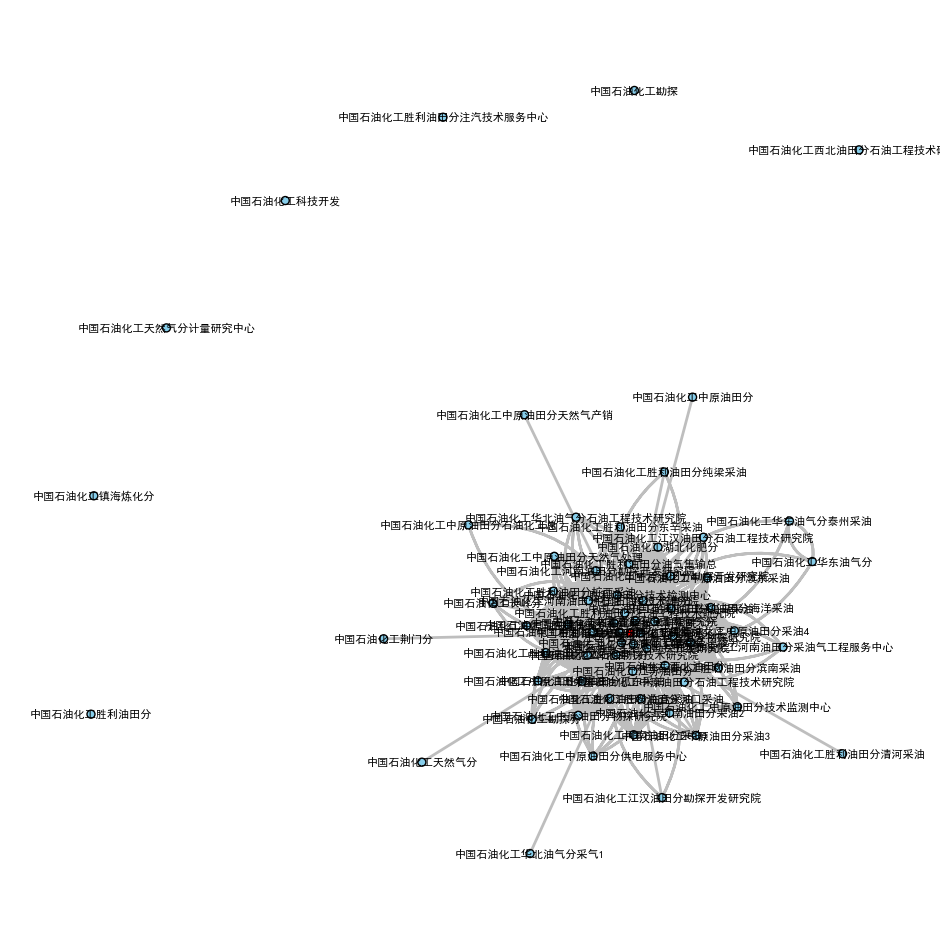

In [40]:
target_company = "中国石油化工"
g=snapshots[2018]
target_nodes = [v.index for v in g.vs if target_company in v['name']] 

subgraph = g.subgraph(target_nodes)
node_colors = ["red" if v['name'] == target_company else "skyblue" for v in subgraph.vs] # 查找目标公司相关节点

# 设置布局
layout = subgraph.layout("fr")  # 使用 Fruchterman-Reingold 力导布局

fig, ax = plt.subplots(figsize=(12, 12))

ig.plot(
    subgraph,
    layout=layout,
    vertex_color=node_colors,
    vertex_size=8,
    edge_color="gray",
    vertex_label=subgraph.vs["name"],  # 设置标签为节点名称
    font_family='SimHei',
    vertex_label_size=8,  # 调整字体大小
    target=ax
)

plt.show()

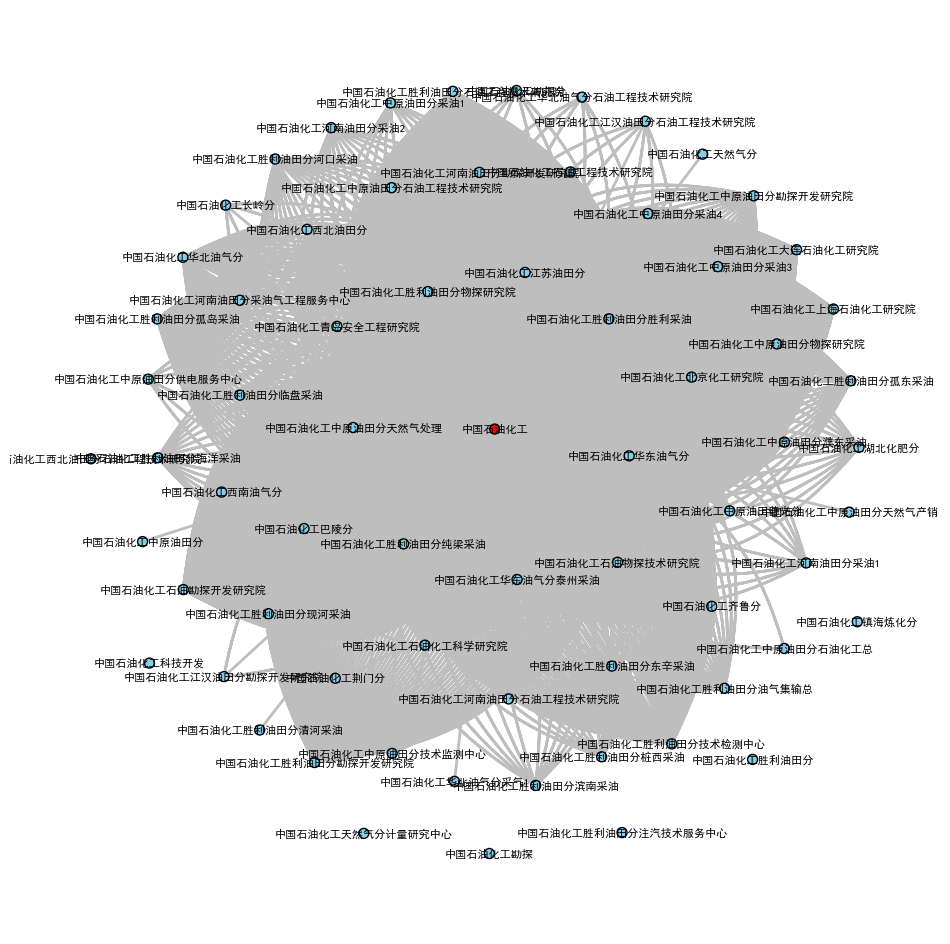

In [30]:
subgraph = g.subgraph(target_nodes)

node_colors = ["red" if v['name'] == target_company else "skyblue" for v in subgraph.vs] # 查找目标公司相关节点

# 设置布局
layout = subgraph.layout("kk")  # star,lgl,drl,drl

fig, ax = plt.subplots(figsize=(12, 12))

ig.plot(
    subgraph,
    layout=layout,
    vertex_color=node_colors,
    vertex_size=10,
    edge_color="gray",
    vertex_label=subgraph.vs["name"],  # 设置标签为节点名称
    font_family='SimHei',
    vertex_label_size=8,  # 调整字体大小
    target=ax
)

plt.show()

In [126]:
from collections import Counter
patent_year_qymc=patent_all_qymc.groupby(['申请年', '企业简称'])['企业名称'].apply(lambda x: sum(x, [])).reset_index()
patent_year_qymc

,申请年,企业简称,企业名称
0,1986.0,湖南冶金材料研究所,"[湖南省冶金材料研究所, 杭州有色金属压延厂, 湖南省冶金材料研究所, 杭州有色金属压延厂]"
1,1986.0,马鞍山钢铁,"[冶金工业部马鞍山钢铁设计研究院, 马鞍山钢铁公司]"
2,1987.0,上海阀门,"[机械工业委员会哈尔滨焊接研究所, 上海阀门厂, 机械工业委员会哈尔滨焊接研究所, 上海阀门厂]"
3,1987.0,新余钢铁,"[冶金工业部建筑研究总院, 新余钢铁厂, 冶金工业部建筑研究总院, 新余钢铁厂]"
4,1987.0,湖南冶金材料研究所,"[冶金工业部钢铁研究总院, 湖南省冶金材料研究所, 冶金工业部钢铁研究总院, 湖南省冶金材料..."
...,...,...,...
24115,2018.0,齐鲁天和惠世制药,"[齐鲁天和惠世制药有限公司, 齐鲁天和惠世(乐陵)制药有限公司, 齐鲁天和惠世制药有限公司,..."
24116,2018.0,龙利得包装印刷,"[龙利得包装印刷股份有限公司, 奉其奉印刷科技(上海)有限公司, 龙利得包装印刷股份有限公司..."
24117,2018.0,龙岩亿隆电力设备,"[龙岩亿隆电力设备有限公司, 厦门威尔圣电气股份有限公司, 龙岩亿隆电力设备有限公司, 厦门..."
24118,2018.0,龙建路桥,"[龙建路桥股份有限公司, 黑龙江省龙建路桥第二工程有限公司]"


In [19]:
patent_year_qymc= patent_all_qymc[['申请年','企业名称','企业简称']].copy()
patent_year_qymc = patent_year_qymc.explode('企业名称').explode('企业简称')
patent_year_qymc.shape#(715423, 3)

(1717320, 3)

In [20]:
patent_year_qymc=patent_year_qymc.groupby(['申请年', '企业简称'])['企业名称'].apply(lambda x: x.to_list()).reset_index()
patent_year_qymc#54671

,申请年,企业简称,企业名称
0,1986.0,冶金工业部马鞍山钢铁设计研究院,"[冶金工业部马鞍山钢铁设计研究院, 马鞍山钢铁公司]"
1,1986.0,杭州有色金属压延,"[湖南省冶金材料研究所, 杭州有色金属压延厂, 湖南省冶金材料研究所, 杭州有色金属压延厂]"
2,1986.0,湖南冶金材料研究所,"[湖南省冶金材料研究所, 杭州有色金属压延厂, 湖南省冶金材料研究所, 杭州有色金属压延厂]"
3,1986.0,马鞍山钢铁,"[冶金工业部马鞍山钢铁设计研究院, 马鞍山钢铁公司]"
4,1987.0,上海阀门,"[机械工业委员会哈尔滨焊接研究所, 上海阀门厂, 机械工业委员会哈尔滨焊接研究所, 上海阀门厂]"
...,...,...,...
54674,2018.0,龙口南山铝压延新材料,"[山东南山铝业股份有限公司, 龙口南山铝压延新材料有限公司, 航鑫材料科技有限公司, 烟台南..."
54675,2018.0,龙岩亿隆电力设备,"[龙岩亿隆电力设备有限公司, 厦门威尔圣电气股份有限公司, 龙岩亿隆电力设备有限公司, 厦门..."
54676,2018.0,龙岩大北农生物科技,"[龙岩大北农生物科技有限公司, 漳州大北农农牧科技有限公司, 北京大北农科技集团股份有限公司..."
54677,2018.0,龙建路桥,"[龙建路桥股份有限公司, 黑龙江省龙建路桥第二工程有限公司]"


In [127]:
Counter(patent_year_qymc.loc[0,'企业名称'])

Counter({'湖南省冶金材料研究所': 2, '杭州有色金属压延厂': 2})

In [ ]:
vertex_df = pd.DataFrame({"id": graph.vs.indices, "name": graph.vs["name"]}) 
vertex_df.to_csv("nodes.csv", index=False) # 边数据
edge_df = pd.DataFrame(graph.get_edgelist(), columns=["source", "target"])
edge_df.to_csv("edges.csv", index=False) 

In [ ]:
for v in graph.vs:
    node = Node("Node", id=v.index, name=v["name"]) neo4j_graph.create(node) # 导入边 
for e in graph.es:
    source = graph.vs[e.source]["name"]
    target = graph.vs[e.target]["name"]
    node_a = neo4j_graph.nodes.match("Node", name=source).first()
    node_b = neo4j_graph.nodes.match("Node", name=target).first()
    relationship = Relationship(node_a, "RELATION", node_b)
    neo4j_graph.create(relationship) 